In [7]:
import cv2 as cv
import argparse
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [8]:
!ls

deploy.prototxt                houghlines.jpg
edge and line detection.ipynb  label_corners.py
edge.py                        test.png
hed_pretrained_bsds.caffemodel test_concat.png


In [65]:
img = Image.open('test.png')
img = np.array(img)

(3024, 4032, 3)


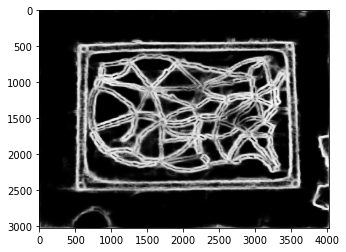

In [66]:
plt.imshow(img)
print(img.shape)

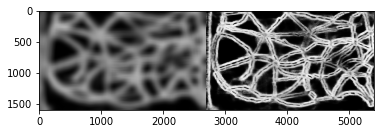

In [69]:
center = img[700:2300, 600:3300]
blur = cv.GaussianBlur(center, (301,301), 0)
display = np.concatenate([blur, center], axis=1)
plt.imshow(display)

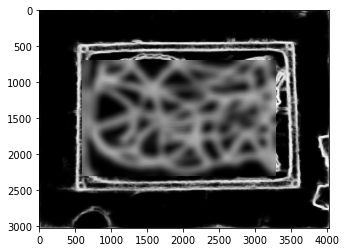

In [71]:
imgcopy = img.copy()
imgcopy[700:2300, 600:3300] = blur
plt.imshow(imgcopy)

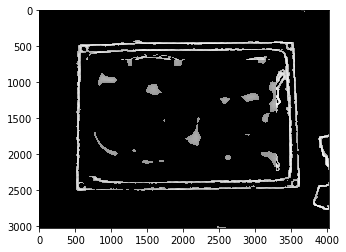

In [72]:
imgcopy[imgcopy < 150] = 0
plt.imshow(imgcopy)

In [94]:
gray = cv.cvtColor(imgcopy,cv.COLOR_BGR2GRAY)
minLineLength = 500
maxLineGap = 10
lines = cv.HoughLinesP(gray,1,np.pi/180,100,minLineLength,maxLineGap)
hough = np.zeros((3024, 4032))
for line in lines[:10]:
    line = line[0]
    x1,y1,x2,y2 = line[0], line[1], line[2], line[3]
    cv.line(hough,(x1,y1),(x2,y2),(255,0,0),5)

In [95]:
print(lines[:10])

[[[1341  456 3546  456]]

 [[1337  450 3539  450]]

 [[1338  452 3541  452]]

 [[3536 2354 3630 2352]]

 [[ 522 2503 1078 2493]]

 [[ 518 2500 1166 2488]]

 [[3436  532 3552  530]]

 [[ 526 2505  677 2502]]

 [[1225  574 3279  539]]

 [[ 808  571 2781  536]]]


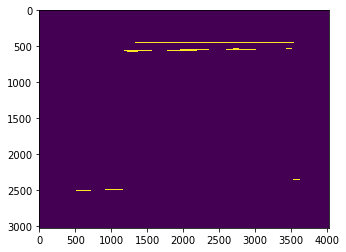

In [96]:
plt.imshow(hough)

In [2]:
# parser = argparse.ArgumentParser(
#         description='This sample shows how to define custom OpenCV deep learning layers in Python. '
#                     'Holistically-Nested Edge Detection (https://arxiv.org/abs/1504.06375) neural network '
#                     'is used as an example model. Find a pre-trained model at https://github.com/s9xie/hed.')
# parser.add_argument('--input', help='Path to image or video. Skip to capture frames from camera')
# parser.add_argument('--write_video', help='Do you want to write the output video', default=False)
# parser.add_argument('--prototxt', help='Path to deploy.prototxt',default='deploy.prototxt', required=False)
# parser.add_argument('--caffemodel', help='Path to hed_pretrained_bsds.caffemodel',default='hed_pretrained_bsds.caffemodel', required=False)
# parser.add_argument('--width', help='Resize input image to a specific width', default=500, type=int)
# parser.add_argument('--height', help='Resize input image to a specific height', default=500, type=int)
# parser.add_argument('--savefile', help='Specifies the output video path', default='output.mp4', type=str)
# args = parser.parse_args()

prototxt = 'deploy.prototxt'
caffemodel = 'hed_pretrained_bsds.caffemodel'
filepath = ''

In [3]:
class CropLayer(object):
    def __init__(self, params, blobs):
        self.xstart = 0
        self.xend = 0
        self.ystart = 0
        self.yend = 0

    # Our layer receives two inputs. We need to crop the first input blob
    # to match a shape of the second one (keeping batch size and number of channels)
    def getMemoryShapes(self, inputs):
        inputShape, targetShape = inputs[0], inputs[1]
        batchSize, numChannels = inputShape[0], inputShape[1]
        height, width = targetShape[2], targetShape[3]

        self.ystart = (inputShape[2] - targetShape[2]) // 2
        self.xstart = (inputShape[3] - targetShape[3]) // 2
        self.yend = self.ystart + height
        self.xend = self.xstart + width

        return [[batchSize, numChannels, height, width]]

    def forward(self, inputs):
        return [inputs[0][:,:,self.ystart:self.yend,self.xstart:self.xend]]

In [4]:
cv.dnn_registerLayer('Crop', CropLayer)

In [5]:
# Load the model.
net = cv.dnn.readNet(prototxt, caffemodel)

In [8]:
## Create a display window
def find_edges(filepath):
    kWinName = 'Holistically-Nested_Edge_Detection'
    cv.namedWindow(kWinName, cv.WINDOW_AUTOSIZE)

    cap = cv.VideoCapture(filepath if filepath else 0)
    hasFrame, frame = cap.read()
    width = frame.shape[1]
    height = frame.shape[0]
    inp = cv.dnn.blobFromImage(frame, scalefactor=1.0, size=(width, height),
                               mean=(104.00698793, 116.66876762, 122.67891434),
                               swapRB=False, crop=False)
    net.setInput(inp)
    out = net.forward()
    out = out[0, 0]
    out = cv.resize(out, (frame.shape[1], frame.shape[0]))
    out = 255 * out
    out = out.astype(np.uint8)
    bgrout=cv.cvtColor(out,cv.COLOR_GRAY2BGR)
    con=np.concatenate((frame,bgrout),axis=1)
    return out, bgrout, con

In [7]:
# cv.imshow(kWinName,con)

# # Determine contour of all blobs found
# _, contours0, hierarchy = cv.findContours( out.copy(), cv.RETR_TREE, cv.CHAIN_APPROX_NONE)
# contours = [cv.approxPolyDP(cnt, 3, True) for cnt in contours0]

# # Draw all contours
# vis = np.zeros((h, w, 3), np.uint8)
# cv.drawContours( vis, contours, -1, (128,255,255), 3, cv.LINE_AA)

# cv.imwrite('contours.png', vis)

# lines = cv.HoughLines(out, 1, np.pi/180, 100) # img, rho sensitivity, theta sensitivity, threshold
# for rho,theta in lines[0]:
#     a = np.cos(theta)
#     b = np.sin(theta)
#     x0 = a*rho
#     y0 = b*rho
#     x1 = int(x0 + height*(-b))
#     y1 = int(y0 + width*(a))
#     x2 = int(x0 - height*(-b))
#     y2 = int(y0 - width*(a))
#     cv.line(out,(x1,y1),(x2,y2),(0,0,255),2)
def hough():
    minLineLength = 100
    maxLineGap = 10
    lines = cv.HoughLinesP(out, 1, np.pi/180, 100, minLineLength, maxLineGap)
    for x1,y1,x2,y2 in lines[0]:
        cv.line(out, (x1,y1), (x2,y2), (255,0,0), 5)
    print(lines[0])


    cv.imwrite('houghlines.jpg',out)
    cv.imwrite('test.png', bgrout)
    cv.imwrite('test_concat.png', con)

    # cv.waitKey(0)
    cv.destroyAllWindows()

In [ ]:
out, bgrout, con = find_edges('../board_images/IMG_4173.jpg')

In [ ]:
plt.imshow(out)